<a href="https://colab.research.google.com/github/carlosemiliorabazo/deepLearning/blob/master/3_3_Regresion_Prediccion_Precio_Casas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

'2.6.0'

# Prediciendo precios de casas: Un ejemplo de regresion
----
La **"regresión"**, consiste en predecir un valor continuo de una etiqueta discreta. Por ejemplo, predecir la temperatura de mañana, dados los datos meteorológicos, o predecir el tiempo en que un proyecto de software tardará en completarse, dadas sus especificaciones.

No confundir "regresión" con el algoritmo "regresión logística": confusamente, "regresión logística" no es un algoritmo de regresión,
es un algoritmo de clasificación.

## El conjunto de datos de Precios de Casas de Boston

Vamos a **predecir** el **precio medio** de las viviendas en un suburbio determinado de **Boston** a mediados de la década de 1970, dados algunos puntos de datos sobre el suburbio en ese momento, como la tasa de criminalidad, la tasa de impuesto a la propiedad local, etc.

El conjunto de datos que usaremos tiene otra diferencia interesante con nuestros dos ejemplos anteriores: **tiene muy pocos puntos de datos**, solo 506 en total, dividido entre 404 muestras de entrenamiento y 102 muestras de prueba, y **cada "característica"** en los datos de entrada (por ejemplo, la tasa de criminalidad) es una característica que tiene una **escala diferente**. Por ejemplo, algunos valores son proporciones, que toman valores entre 0 y 1, otros toman valores entre 1 y 12, otros entre 0 y 100 ... 

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_data[1]

array([2.1770e-02, 8.2500e+01, 2.0300e+00, 0.0000e+00, 4.1500e-01,
       7.6100e+00, 1.5700e+01, 6.2700e+00, 2.0000e+00, 3.4800e+02,
       1.4700e+01, 3.9538e+02, 3.1100e+00])

Tenemos 404 muestras de entrenamiento y 102 muestras de prueba. Los datos comprenden 13 características:

1. Tasa de delincuencia per cápita.
2. Proporción de terreno residencial dividido en zonas para lotes de más de 25k pies cuadrados.
3. Proporción de acres comerciales no minoristas por ciudad.
4. Variable ficticia de Charles River (= 1 si el tramo limita con el río; 0 en caso contrario).
5. Concentración de óxidos nítricos (partes por 10 millones).
6. Número medio de habitaciones por vivienda.
7. Proporción de unidades ocupadas por sus propietarios construidas antes de 1940.
8. Distancias ponderadas a cinco centros de empleo de Boston.
9. Índice de accesibilidad a carreteras radiales.
10. Tasa de impuesto a la propiedad de valor total por 10K dólares.
11. Proporción alumno-profesor por municipio.
12. 1000 * (Bk - 0,63) ** 2 donde Bk es la proporción de personas de color por ciudad.
13. % menor situación de la población.

Los objetivos son los valores medios de las viviendas ocupadas por sus propietarios, en miles de dólares:

In [6]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

Los precios suelen oscilar entre 10K dólares y 50K dólares. Recordar que esto fue a mediados de la década de 1970, y estos precios no se han ajustado por la inflación.

## Preparando los datos

* Problemático alimentar a una red neuronal con valores que toman rangos tremendamente diferentes (la red podría adaptarse automáticamente a datos tan heterogéneos, pero dificultaría el aprendizaje)
* Cuando pase esto debemos hacer una **normalización en relación a las características**: para cada característica en los datos de entrada (una columna en la matriz de datos de entrada), **restamos la media de la característica** y la **dividiremos por la desviación estándar**, de modo que **la característica se centrará alrededor de 0** y tendrá una **desviación estándar unitaria**. Esto se hace fácilmente en Numpy:

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

* Tener en cuenta que las **cantidades** que utilizamos **para normalizar los datos de prueba** se han calculado **utilizando los datos de entrenamiento**. 
* **Nunca debemos usar** en nuestro flujo de trabajo cualquier **cantidad calculada en los datos de prueba**, **incluso para** algo tan simple como **la normalización de datos**.

## Construyendo la red

Debido a que hay tan **pocas muestras disponibles**, usaremos una **red muy pequeña** con **dos capas ocultas**, cada una con 64 unidades. En general, **cuantos menos datos de entrenamiento tenga, peor será el sobreajuste y el uso una red pequeña es una forma de reducir el sobreajuste**.

In [ ]:
import tensorflow as tf
from keras import models
from keras import layers

def build_model():
    # Porque necesitaremos instanciar el mismo modelo 
    # múltiples veces, usamos una función para construirlo
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()]) # metrics = ['mae']
    return model

* Nuestra red **termina** con **una sola unidad** y **sin activación** (es decir, **será una capa lineal**).
* **Configuración típica para la regresión escalar** (es decir, regresión en la que intentamos predecir un único valor continuo).
  - La aplicación de una función de activación limitaría el rango que puede tomar la salida; por ejemplo si aplicamos una función de activación "sigmoide" a nuestra última capa, la red solo aprendería a predecir valores entre 0 y 1. 
  - Aquí, porque la última capa es puramente lineal, la red es libre de aprender a predecir valores en cualquier rango.
* Compilamos la red con la función de pérdida `mse` (**error cuadrático medio**, el cuadrado de la diferencia entre predicciones y los objetivos, una **función de pérdida ampliamente utilizada para problemas de regresión**)
* Estamos monitorizando una nueva métrica durante el entrenamiento: `mae` **error absoluto medio** (valor absoluto de la diferencia entre las predicciones y los objetivos). Por ejemplo, un MAE de 0.5 en este problema significaría que nuestras predicciones están equivocadas por 500 dólares en promedio.

## Validando nuestro enfoque usando la **validación K-fold o K-iteraciones**

* Para evaluar nuestra red mientras seguimos ajustando sus parámetros (número de épocas), **podríamos dividir** los datos en un conjunto de **entrenamiento** y un conjunto de **validación**.
* Como tenemos tan **pocos datos**, conjunto de validación sería muy pequeño
  - Consecuencia: nuestras puntuaciones de validación pueden cambiar mucho dependiendo de los puntos de datos que elijamos usar para la validación y cuales elijamos para el  entrenamiento (las puntuaciones de validación podrían tener **alta varianza** con respecto a la división de validación). Esto impide una evaluación fiable del modelo.
* En estos casos utilizamos la **validación cruzada de K-fold (k-iteraciones)**:
  - Consiste en **dividir los datos disponibles en K particiones** (típicamente **K = 4** o **5**)
  - Luego utilizando **instancias de K modelos idénticos** y entrenando cada uno en K-1 particiones mientras se evalúa la partición restante. 
* La puntuación de la validación para el modelo utilizado sería entonces el **promedio de las puntuaciones de las K validaciones obtenidas**.

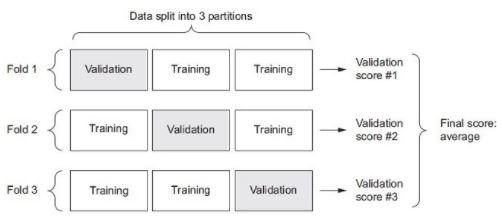

En términos de código, esto es sencillo:

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Preparamos la validación de los datos: datos de la partición #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Preparamos los datos de entrenamiento: Datos de las demás particiones
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Construcción del modelo Keras (ya compilado)
    model = build_model()
    # Entrenando el modelo (en modo silencioso, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evalua el modelo sobre los datos de validación
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
all_scores

[2.1789305210113525, 2.500786304473877, 2.704835891723633, 2.5385119915008545]

In [ ]:
np.mean(all_scores)

2.480766177177429

* Se puede ver que diferentes ejecuciones muestran puntuajes de validación bastante diferentes, de 2.1 (2.5) a 2.9 (3.2). 
* El promedio (2.4) o (3.0) es una métrica mucho más confiable que cualquier puntuación individual; esa es la clave de la validación cruzada de K-iteraciones.
* En este caso, nos desviamos una media de 2.400 (3K) dólares, significativo considerando que los precios oscilan entre 10K dólares y 50K dólares.

Vamos a entrenar la red un poco más de tiempo: **500 repeticiones**. Para mantener un registro de cómo de bien funciona el modelo en cada repetición, modificaremos nuestro ciclo de entrenamiento para guardar el registro de puntuación de validación por repetición:

In [ ]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

In [ ]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Preparamos la validación de los datos: datos de la partición # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Preparamos los datos de entrenamiento: Datos de todas la demás particiones
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Construcción del modelo Keras (ya compilado)
    model = build_model()
    # Entrenando el modelo (en modo silencioso, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


A continuación, podemos calcular el promedio de las puntuaciones MAE por repetición para todas los iteraciones:

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Lo pintamos:

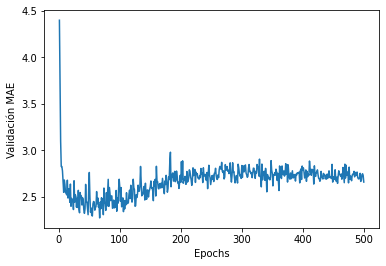

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validación MAE')
plt.show()

Puede ser un poco difícil ver el gráfico debido a problemas de escala y la varianza relativamente alta. Vamos a:

* Omitir los primeros 10 puntos de datos, que están en una escala diferente del resto de la curva.
* Reemplazar cada punto con una media móvil exponencial de los puntos anteriores para obtener una curva suave.

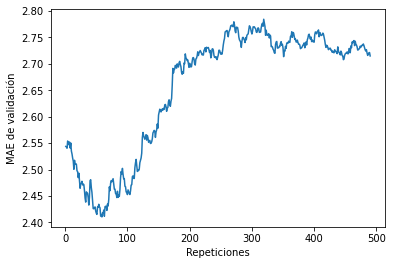

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Repeticiones')
plt.ylabel('MAE de validación')
plt.show()

Según este gráfico, parece que el **MAE de validación deja de mejorar significativamente después de 80 repeticiones**. Pasado ese punto, comenzamos a sobreajustar.

Una vez que hayamos terminado de ajustar otros parámetros de nuestro modelo (además del número de repeticiones, también podríamos ajustar el tamaño de las capas ocultas), podemos **entrenar un modelo de "producción" final** en todos los datos de entrenamiento, **con los mejores parámetros**, y luego observar su rendimiento en los datos de prueba:

In [ ]:
# Obtenemos un modelo compilado nuevo
model = build_model()
# Lo entrenamos en todos los datos.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 16.9709 - mean_absolute_error: 2.5990


In [ ]:
test_mae_score

2.5989582538604736

Todavía estamos desviados en alrededor de 2.550 dólares

## Resumiendo

Esto es lo que se debería sacar de este ejemplo:

* La regresión se realiza utilizando funciones de pérdida diferentes a las usadas en la clasificación; El **error cuadrático medio (MSE)** es una **función de pérdida de uso común para regresión**.
* De manera similar, las métricas de evaluación que se utilizarán para la regresión difieren de las utilizadas para la clasificación; naturalmente, el concepto de "precisión" o exactitud no aplica para regresión. **Una métrica de regresión común es el error absoluto medio (MAE)**.
* Cuando las características en los datos de entrada tienen **valores en diferentes rangos**, cada característica debe escalarse de forma independiente como paso de preprocesamiento.
* Cuando hay pocos datos disponibles, usar la validación de K-iteraciones es una excelente manera de evaluar un modelo de manera fiable.
* Cuando hay pocos datos de entrenamiento disponibles, es preferible usar una red pequeña con muy pocas capas ocultas (generalmente solo una o dos), para evitar un sobreajuste exagerado.

---